In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heart-attack-analysis-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1226038%2F2047221%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T020114Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D948641425a6804ebc8b841cfc880bf17cc478d78c09453a39e63ef868621b46e4a0550e530baa676e1a9fd088f70a8d175162f6d3658ce9c17d728013603d025abd23724bbafa46d7b216a07a1794671bdbe4aebe8bec9208f3bfc55d32dc9a2a32318c1003b259b4b7e214e88fc73d99358581594342177910a70fffba0afb96d7ca2f91ef5b4d2e09c591323914395205fde96feddead172e7ee824f86f3e2f30a8638e91939fd4e971bdf6b4db95896e7cb9b9b5130bc59e0f98ff443b4c64024b5989c750f4d804bf0580e21e9f4101298658318e5f7f5ef083c94cfa55fc86afa5728c752f087772bc69fce0b00bf85a38411d56f427b4f0cfc8d738bea'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4209 bytes downloaded
Downloaded and uncompressed: heart-attack-analysis-prediction-dataset
Data source import complete.


# Fields and data types 🗒️:
## About this dataset

- **Age**: Age of the patient
- **Sex**: Sex of the patient
- **exang**: Exercise induced angina (1 = yes; 0 = no)
- **ca**: Number of major vessels (0-3)
- **cp**: Chest Pain type
  - Value 1: typical angina
  - Value 2: atypical angina
  - Value 3: non-anginal pain
  - Value 4: asymptomatic
- **trtbps**: Resting blood pressure (in mm Hg)
- **chol**: Cholestoral in mg/dl fetched via BMI sensor
- **fbs**: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- **rest_ecg**: Resting electrocardiographic results
  - Value 0: normal
  - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
  - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- **thalach**: Maximum heart rate achieved
- **target**: 0 = less chance of heart attack, 1 = more chance of heart attack

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Scaling
from sklearn.preprocessing import RobustScaler

# Train Test Split
from sklearn.model_selection import train_test_split

# Models
import torch
import torch.nn as nn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


In [3]:
data = pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv")
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Understanding Data

In [4]:
data.shape

(303, 14)

## Now i going to checking the number of unique values in each column

In [5]:
dict = {}
for i in list(data.columns):
    dict[i] = data[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
age,41
sex,2
cp,4
trtbps,49
chol,152
fbs,2
restecg,3
thalachh,91
exng,2
oldpeak,40


## Separating the columns in categorical and continuous

In [6]:
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]
print("The categorial cols are : ", cat_cols)
print("The continuous cols are : ", con_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']
The continuous cols are :  ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
The target variable is :   ['output']


## Summary statistics

In [7]:
data[con_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


## Missing values

In [8]:
data.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

# EDA (Exploratory Data Analysis)

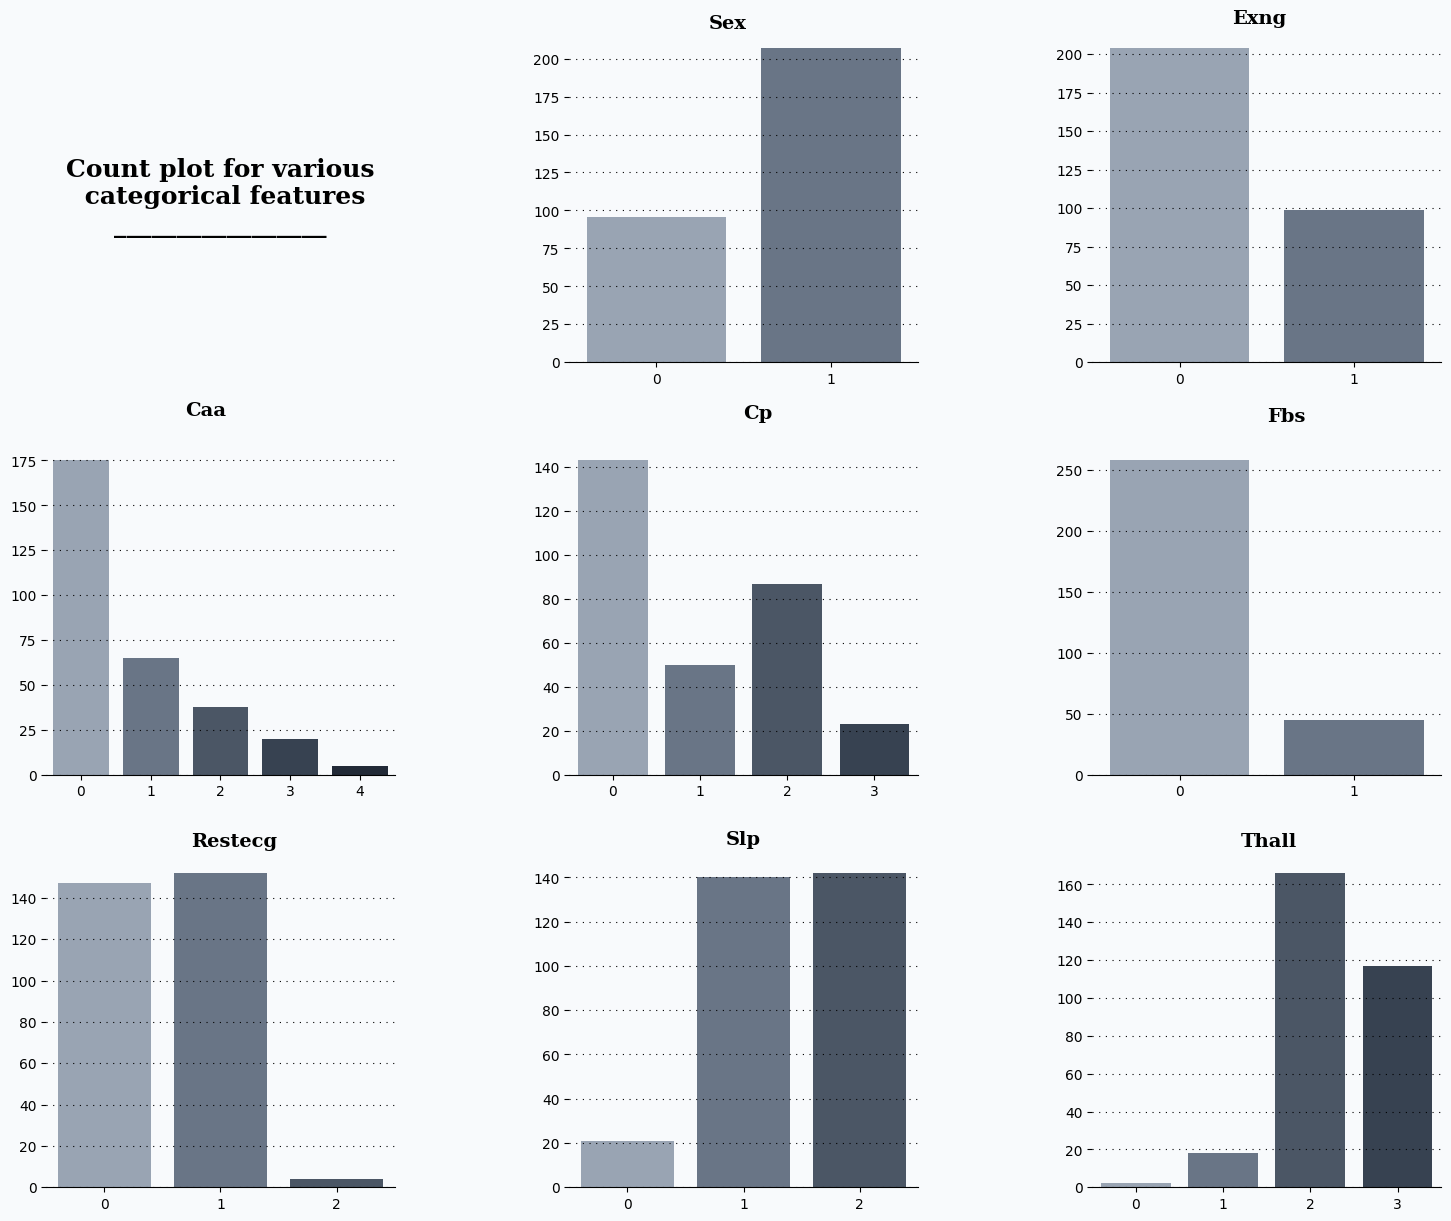

In [9]:
# Count plot of categorical features
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

background_color = "#f8fafc"
color_palette = ["#94a3b8","#64748b","#475569","#334155","#1e293b"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot for various\n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Sex count
ax1.text(0.3, 220, 'Sex', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1,data=data,x='sex',palette=color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Exng count
ax2.text(0.3, 220, 'Exng', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2,data=data,x='exng',palette=color_palette)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Caa count
ax3.text(1.5, 200, 'Caa', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3,data=data,x='caa',palette=color_palette)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Cp count
ax4.text(1.5, 162, 'Cp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax4,data=data,x='cp',palette=color_palette)
ax4.set_xlabel("")
ax4.set_ylabel("")

# Fbs count
ax5.text(0.5, 290, 'Fbs', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax5,data=data,x='fbs',palette=color_palette)
ax5.set_xlabel("")
ax5.set_ylabel("")

# Restecg count
ax6.text(0.75, 165, 'Restecg', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax6,data=data,x='restecg',palette=color_palette)
ax6.set_xlabel("")
ax6.set_ylabel("")

# Slp count
ax7.text(0.85, 155, 'Slp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax7,data=data,x='slp',palette=color_palette)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Thall count
ax8.text(1.2, 180, 'Thall', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax8,data=data,x='thall',palette=color_palette)
ax8.set_xlabel("")
ax8.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

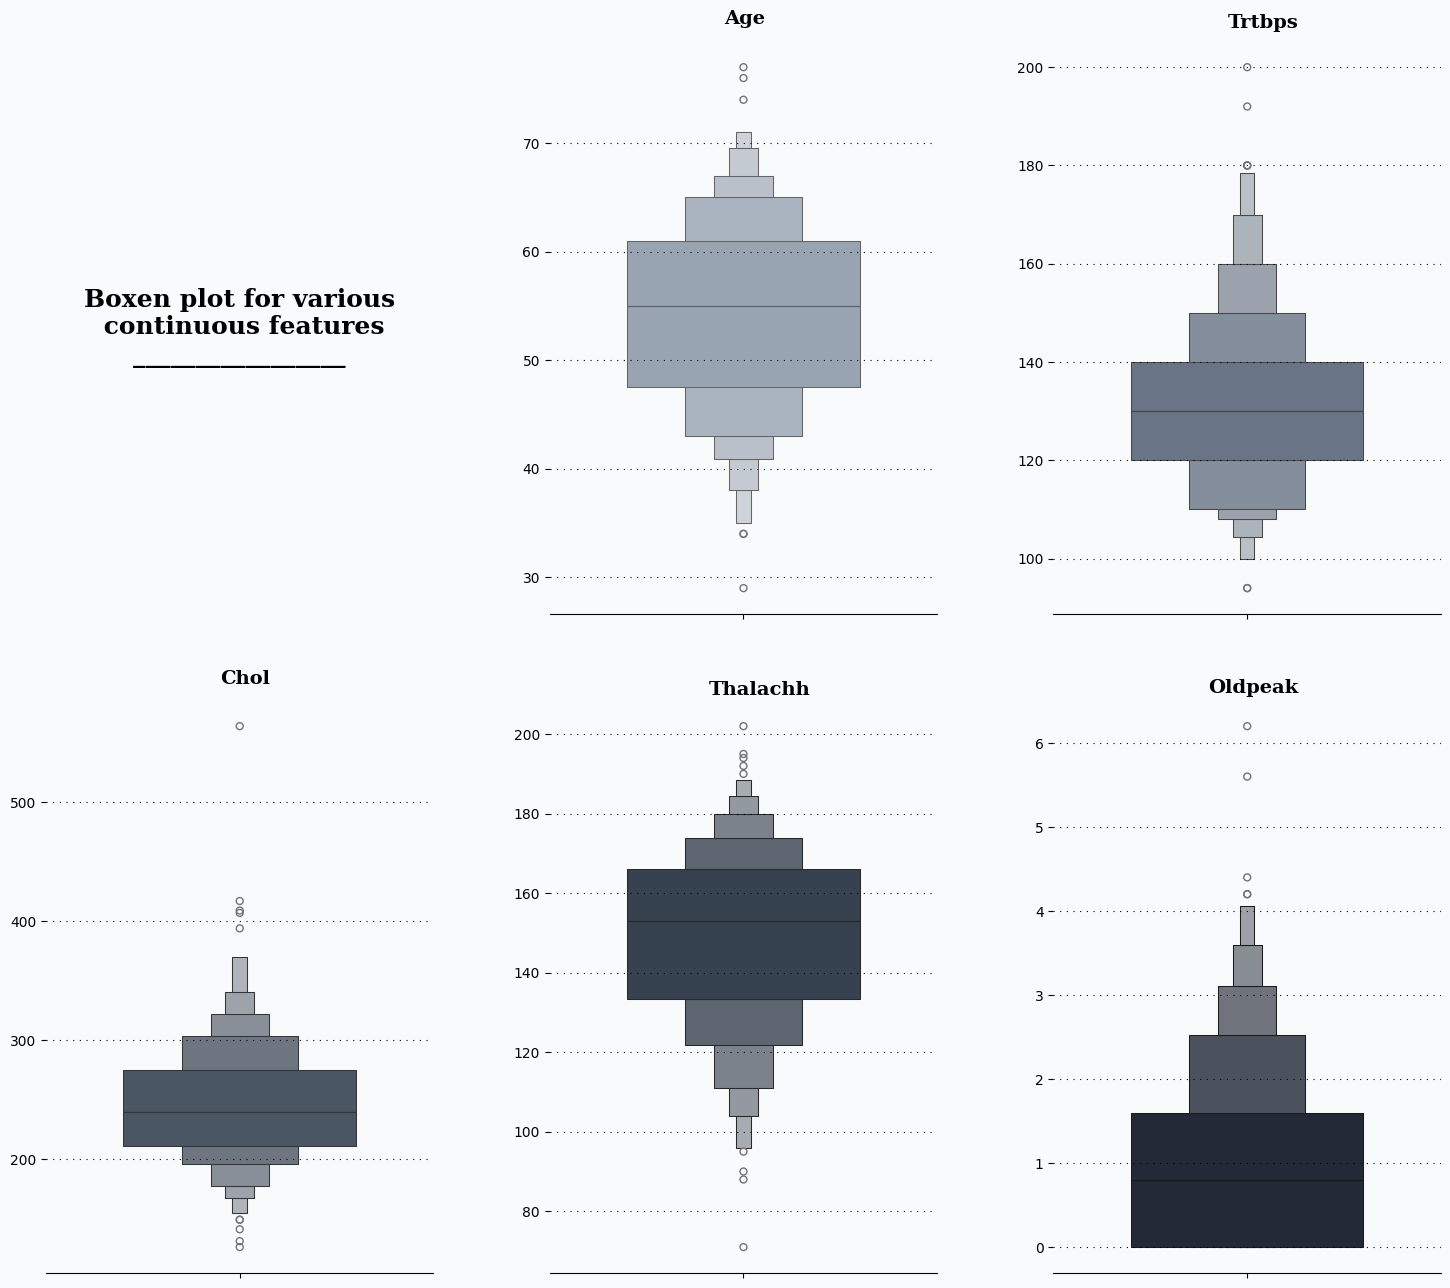

In [10]:
# Boxen plot of continuous features
fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

background_color = "#f8fafc"
color_palette = ["#94a3b8","#64748b","#475569","#334155","#1e293b"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Boxen plot for various\n continuous features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Age
ax1.text(-0.05, 81, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax1,y=data['age'],palette=["#94a3b8"],width=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Trtbps
ax2.text(-0.05, 208, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax2,y=data['trtbps'],palette=["#64748b"],width=0.6)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol
ax3.text(-0.05, 600, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax3,y=data['chol'],palette=["#475569"],width=0.6)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh
ax4.text(-0.09, 210, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax4,y=data['thalachh'],palette=["#334155"],width=0.6)
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak
ax5.text(-0.1, 6.6, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax5,y=data['oldpeak'],palette=["#1e293b"],width=0.6)
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

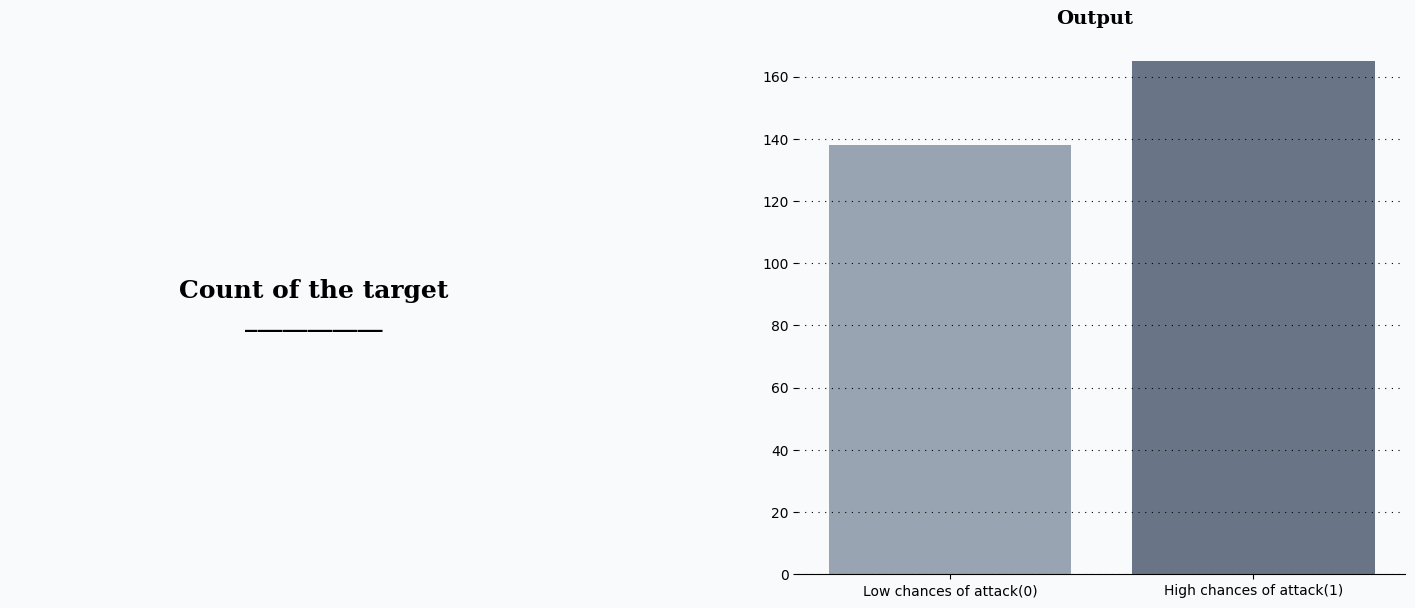

In [11]:
# Count plot of target
fig = plt.figure(figsize=(18,7))
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

background_color = "#f8fafc"
color_palette = ["#94a3b8","#64748b","#475569","#334155","#1e293b"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# Title of the plot
ax0.text(0.5,0.5,"Count of the target\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')

ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Target Count
ax1.text(0.35,177,"Output",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1, data=data, x = 'output',palette = color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticklabels(["Low chances of attack(0)","High chances of attack(1)"])

ax0.spines["top"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)

## Bivariate Analysis
### Correlation matrix of continous features

In [12]:
data_corr = data[con_cols].corr().transpose()
data_corr

,age,trtbps,chol,thalachh,oldpeak
age,1.000000,0.279351,0.213678,-0.398522,0.210013
trtbps,0.279351,1.000000,0.123174,-0.046698,0.193216
chol,0.213678,0.123174,1.000000,-0.009940,0.053952
thalachh,-0.398522,-0.046698,-0.009940,1.000000,-0.344187
oldpeak,0.210013,0.193216,0.053952,-0.344187,1.000000


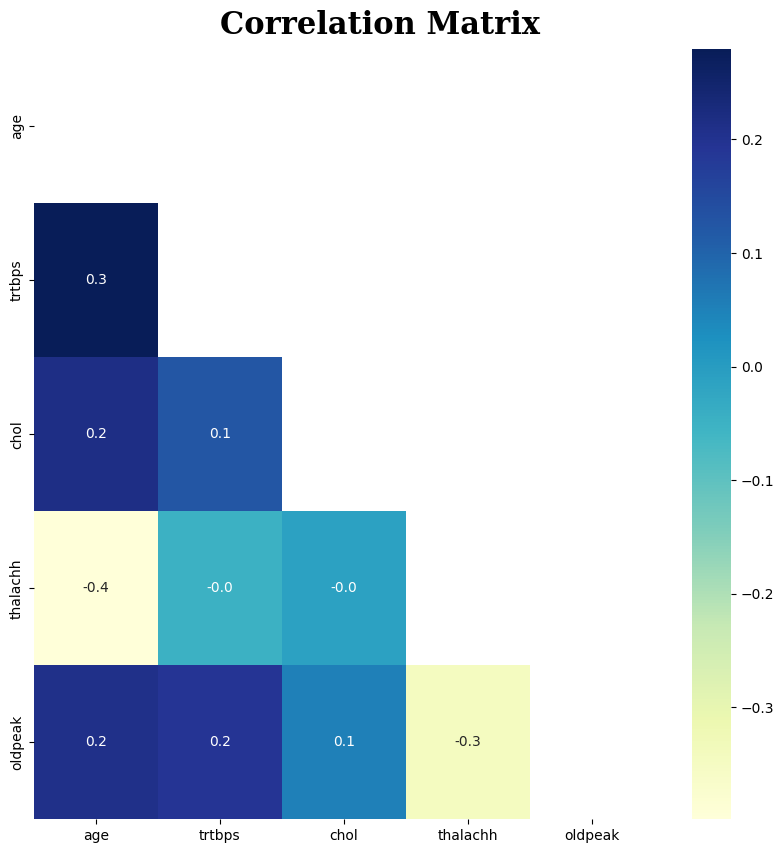

In [13]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])

color_palette = ["#94a3b8","#64748b"]
mask = np.triu(np.ones_like(data_corr))
ax0.text(1.5,-0.1,"Correlation Matrix",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
df_corr = data[con_cols].corr().transpose()
sns.heatmap(df_corr,mask=mask,fmt=".1f",annot=True,cmap='YlGnBu')
plt.show()

<Figure size 1200x1200 with 0 Axes>

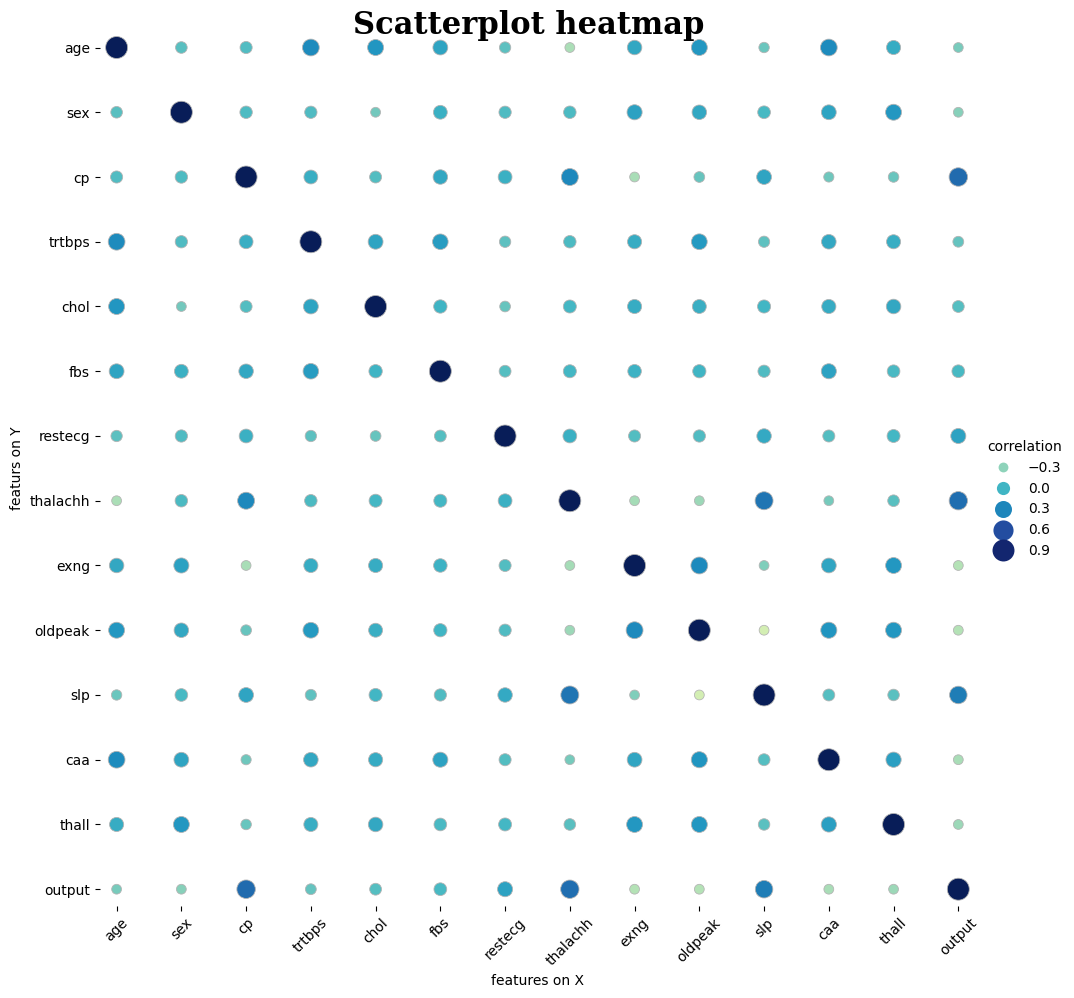

In [14]:
fig = plt.figure(figsize=(12,12))
corr_mat = data.corr().stack().reset_index(name="correlation")
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="YlGnBu", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)
g.set(xlabel="features on X", ylabel="featurs on Y", aspect="equal")
g.fig.suptitle('Scatterplot heatmap',fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(45)
plt.show()

## Distribution of continuous features according to target variable

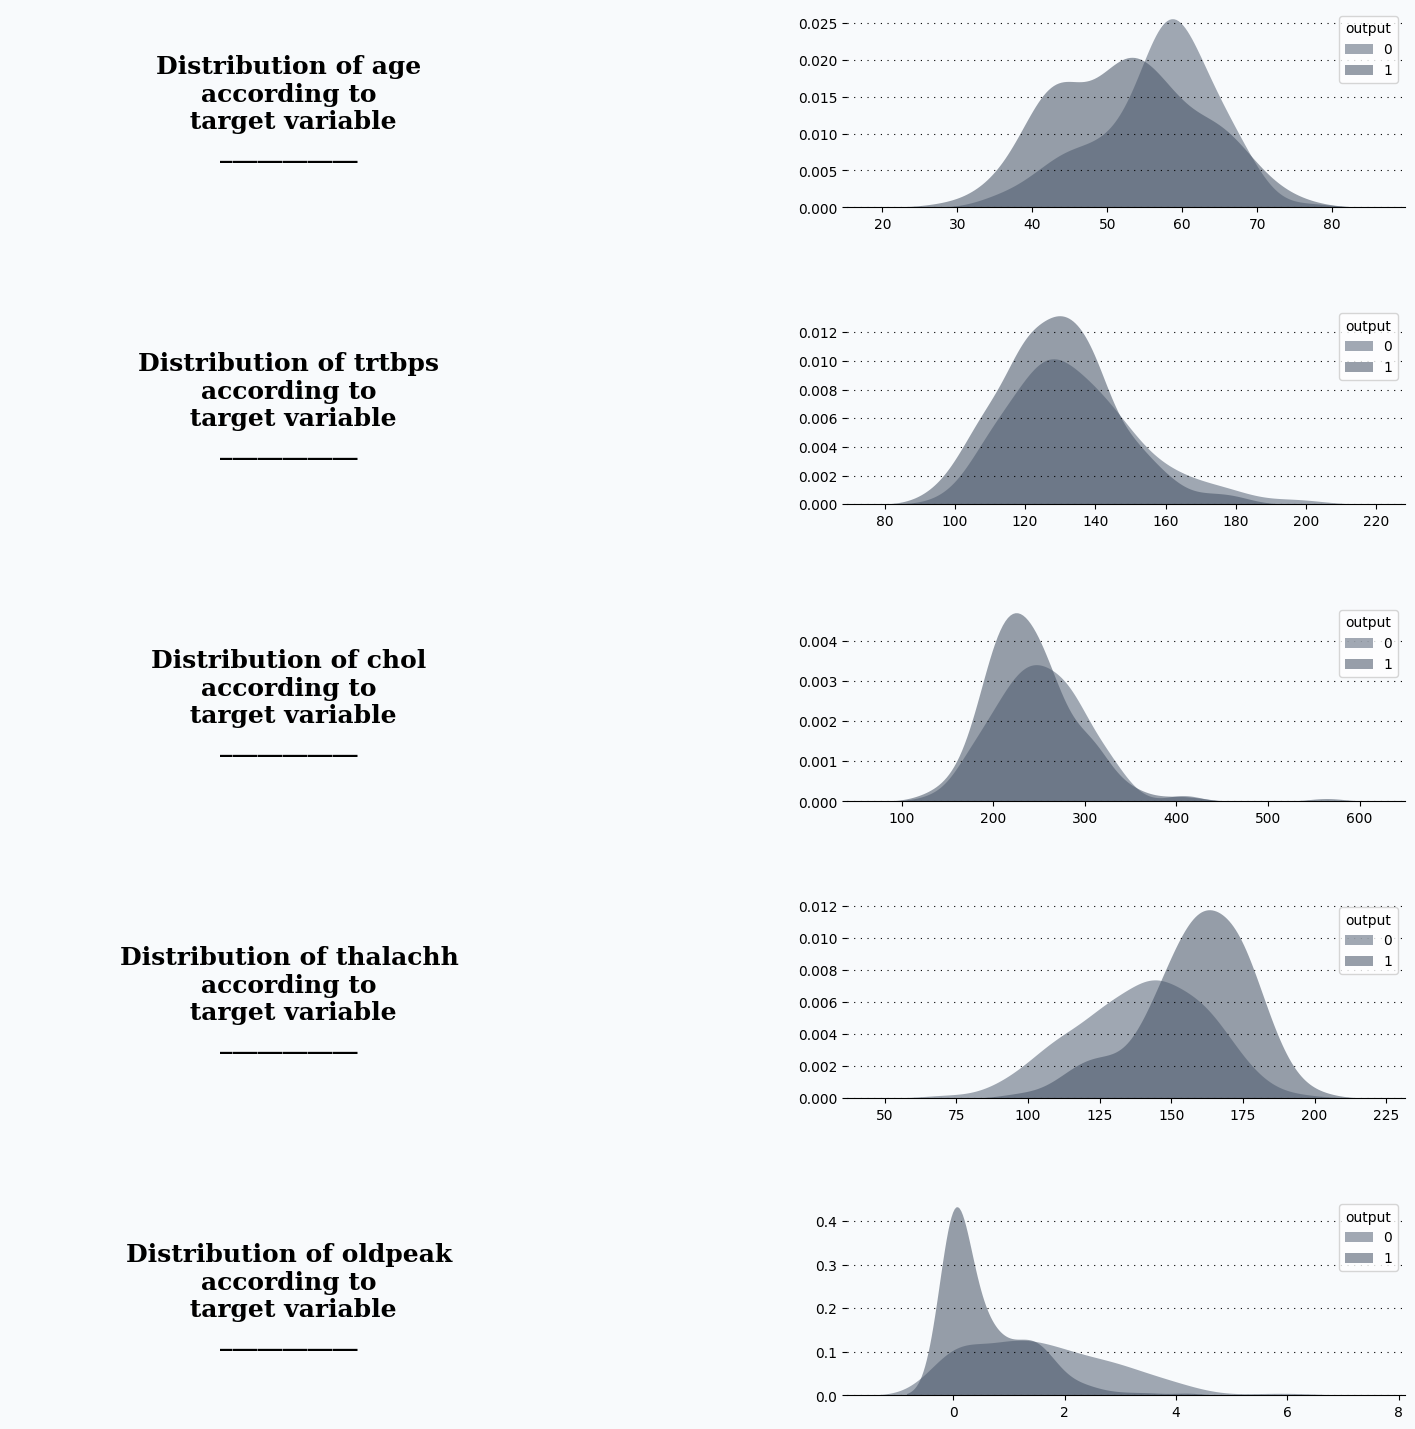

In [15]:
fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(5,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,0])
ax9 = fig.add_subplot(gs[4,1])

background_color = "#f8fafc"
color_palette = ["#94a3b8","#64748b","#475569","#334155","#1e293b"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)
ax9.set_facecolor(background_color)

# Age title
ax0.text(0.5,0.5,"Distribution of age\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax0.spines["bottom"].set_visible(False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Age
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax1, data=data, x='age',hue="output", fill=True,palette=["#475569","#334155"], alpha=.5, linewidth=0)
ax1.set_xlabel("")
ax1.set_ylabel("")

# TrTbps title
ax2.text(0.5,0.5,"Distribution of trtbps\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax2.spines["bottom"].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(left=False, bottom=False)

# TrTbps
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax3, data=data, x='trtbps',hue="output", fill=True,palette=["#475569","#334155"], alpha=.5, linewidth=0)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Chol title
ax4.text(0.5,0.5,"Distribution of chol\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax4.spines["bottom"].set_visible(False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.tick_params(left=False, bottom=False)

# Chol
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax5, data=data, x='chol',hue="output", fill=True,palette=["#475569","#334155"], alpha=.5, linewidth=0)
ax5.set_xlabel("")
ax5.set_ylabel("")

# Thalachh title
ax6.text(0.5,0.5,"Distribution of thalachh\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax6.spines["bottom"].set_visible(False)
ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.tick_params(left=False, bottom=False)

# Thalachh
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax7, data=data, x='thalachh',hue="output", fill=True,palette=["#475569","#334155"], alpha=.5, linewidth=0)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Oldpeak title
ax8.text(0.5,0.5,"Distribution of oldpeak\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax8.spines["bottom"].set_visible(False)
ax8.set_xticklabels([])
ax8.set_yticklabels([])
ax8.tick_params(left=False, bottom=False)

# Oldpeak
ax9.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax9, data=data, x='oldpeak',hue="output", fill=True,palette=["#475569","#334155"], alpha=.5, linewidth=0)
ax9.set_xlabel("")
ax9.set_ylabel("")

for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)
    ax6.spines[i].set_visible(False)
    ax7.spines[i].set_visible(False)
    ax8.spines[i].set_visible(False)
    ax9.spines[i].set_visible(False)

## Some other relations that seemed intuitive

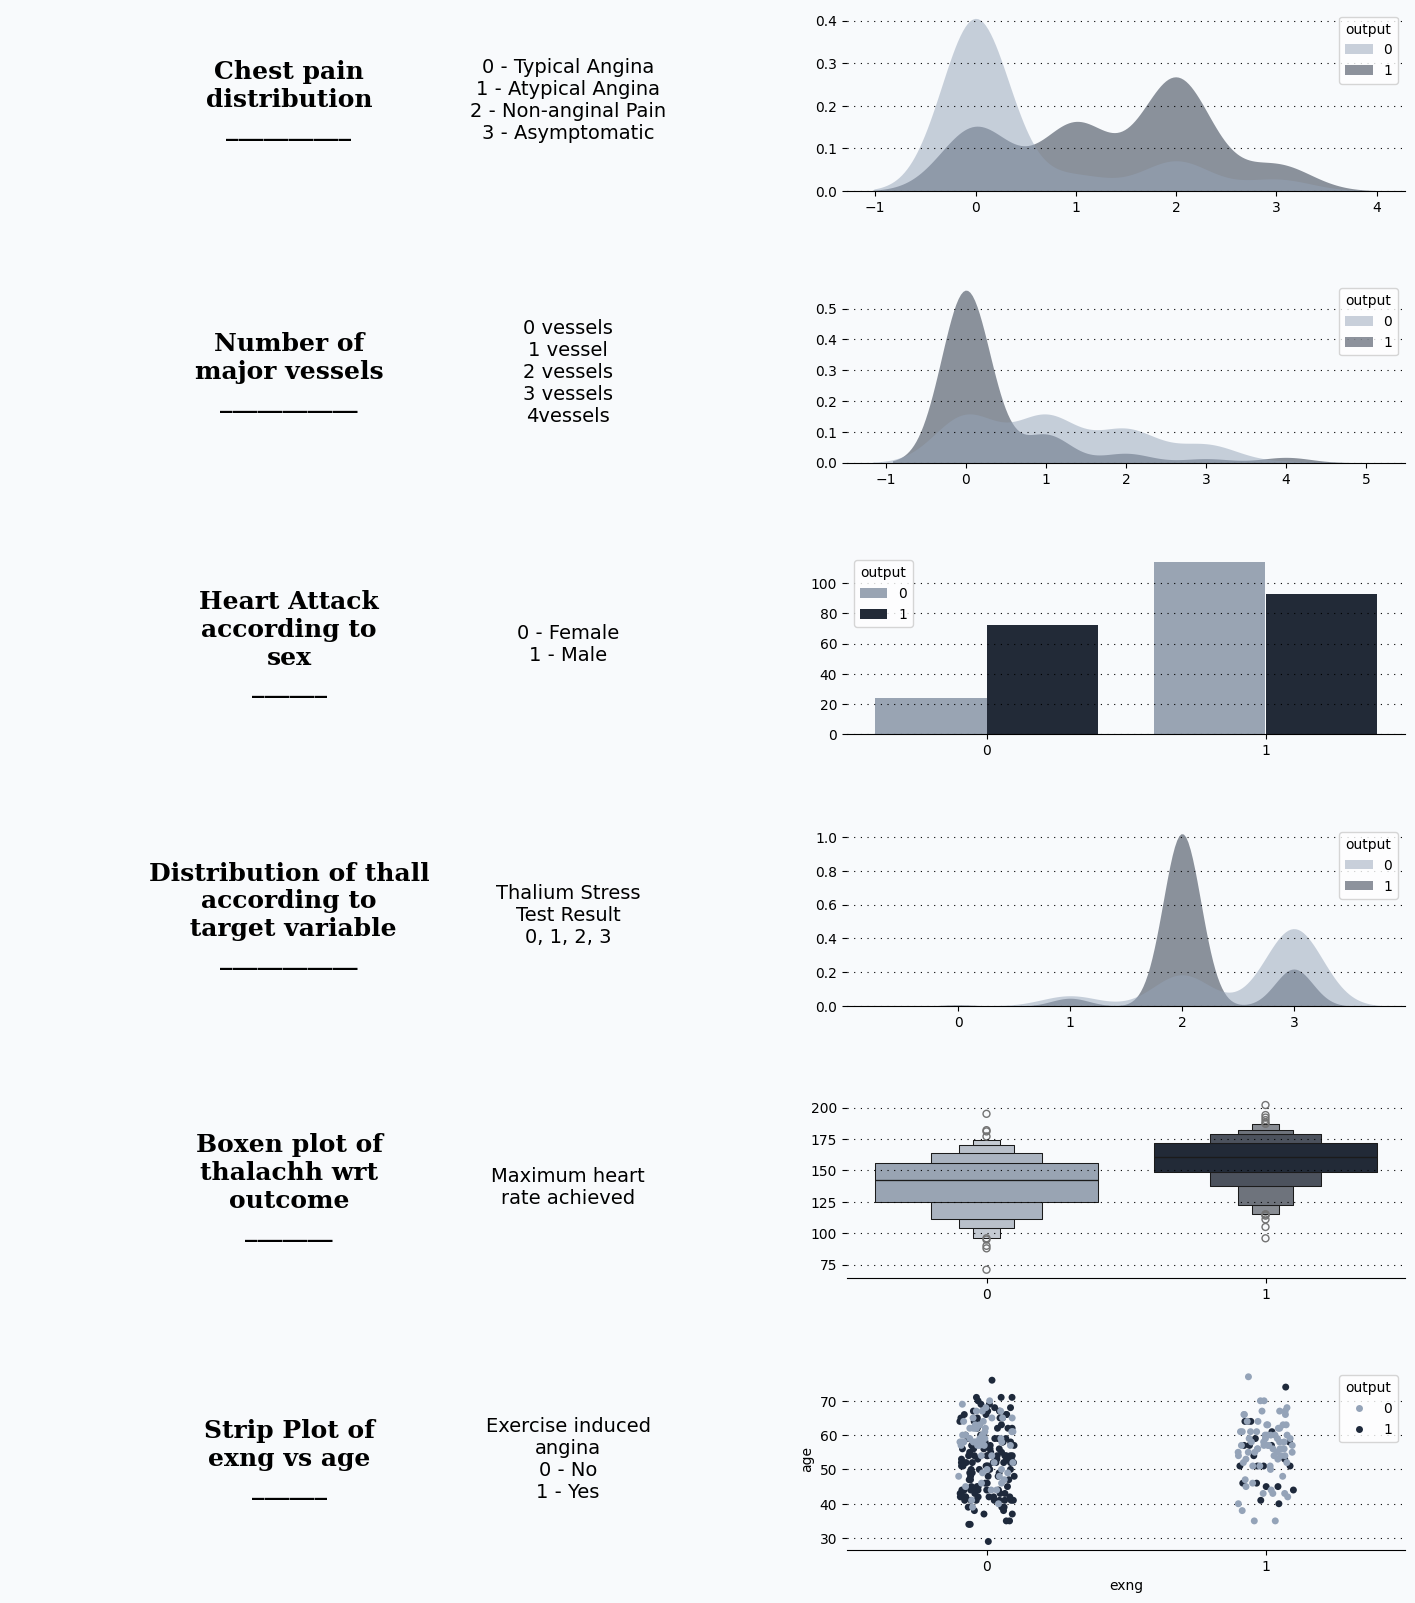

In [16]:
fig = plt.figure(figsize=(18,20))
gs = fig.add_gridspec(6,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,0])
ax9 = fig.add_subplot(gs[4,1])
ax10 = fig.add_subplot(gs[5,0])
ax11 = fig.add_subplot(gs[5,1])

background_color = "#f8fafc"
color_palette = ["#94a3b8","#64748b","#475569","#334155","#1e293b"]

fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)
ax9.set_facecolor(background_color)
ax10.set_facecolor(background_color)
ax11.set_facecolor(background_color)

# Cp title
# 0 = Typical Angina, 1 = Atypical Angina, 2 = Non-anginal Pain, 3 = Asymptomatic
ax0.text(0.5,0.5,"Chest pain\ndistribution\n__________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax0.spines["bottom"].set_visible(False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)
ax0.text(1,.5,"0 - Typical Angina\n1 - Atypical Angina\n2 - Non-anginal Pain\n3 - Asymptomatic",
        horizontalalignment = 'center',
         verticalalignment = 'center',
        fontsize = 14
        )

# Cp
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax1, data=data, x='cp',hue="output", fill=True,palette=["#94a3b8", "#1e293b"], alpha=.5, linewidth=0)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Caa title
ax2.text(0.5,0.5,"Number of\nmajor vessels\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax2.text(1,.5,"0 vessels\n1 vessel\n2 vessels\n3 vessels\n4vessels",
        horizontalalignment = 'center',
         verticalalignment = 'center',
        fontsize = 14
        )

ax2.spines["bottom"].set_visible(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(left=False, bottom=False)

# Caa
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax3, data=data, x='caa',hue="output", fill=True,palette=["#94a3b8", "#1e293b"], alpha=.5, linewidth=0)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Sex title
ax4.text(0.5,0.5,"Heart Attack\naccording to\nsex\n______",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax4.text(1,.5,"0 - Female\n1 - Male",
        horizontalalignment = 'center',
         verticalalignment = 'center',
        fontsize = 14
        )
ax4.spines["bottom"].set_visible(False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.tick_params(left=False, bottom=False)

# Sex
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax5,data=data,x='sex',palette=["#94a3b8", "#1e293b"], hue='output')
ax5.set_xlabel("")
ax5.set_ylabel("")

# Thall title
ax6.text(0.5,0.5,"Distribution of thall\naccording to\n target variable\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax6.text(1,.5,"Thalium Stress\nTest Result\n0, 1, 2, 3",
        horizontalalignment = 'center',
         verticalalignment = 'center',
        fontsize = 14
        )
ax6.spines["bottom"].set_visible(False)
ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.tick_params(left=False, bottom=False)

# Thall
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax7, data=data, x='thall',hue="output", fill=True,palette=["#94a3b8", "#1e293b"], alpha=.5, linewidth=0)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Thalachh title
ax8.text(0.5,0.5,"Boxen plot of\nthalachh wrt\noutcome\n_______",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax8.text(1,.5,"Maximum heart\nrate achieved",
        horizontalalignment = 'center',
         verticalalignment = 'center',
        fontsize = 14
        )

ax8.spines["bottom"].set_visible(False)
ax8.set_xticklabels([])
ax8.set_yticklabels([])
ax8.tick_params(left=False, bottom=False)

# Thalachh
ax9.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax9, data=data,x='output',y='thalachh',palette=["#94a3b8", "#1e293b"])
ax9.set_xlabel("")
ax9.set_ylabel("")



# Exng title
ax10.text(0.5,0.5,"Strip Plot of\nexng vs age\n______",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
ax10.text(1,.5,"Exercise induced\nangina\n0 - No\n1 - Yes",
        horizontalalignment = 'center',
         verticalalignment = 'center',
        fontsize = 14
        )
ax10.spines["bottom"].set_visible(False)
ax10.set_xticklabels([])
ax10.set_yticklabels([])
ax10.tick_params(left=False, bottom=False)


# Exng
ax11.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.stripplot(ax=ax11, data=data,x='exng',y='age',hue='output',palette=["#94a3b8", "#1e293b"])
ax9.set_xlabel("")
ax9.set_ylabel("")

for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)
    ax6.spines[i].set_visible(False)
    ax7.spines[i].set_visible(False)
    ax8.spines[i].set_visible(False)
    ax9.spines[i].set_visible(False)
    ax10.spines[i].set_visible(False)
    ax11.spines[i].set_visible(False)

# Pairplot according to target variable - one plot to rule them all

<Axes: xlabel='age', ylabel='thalachh'>

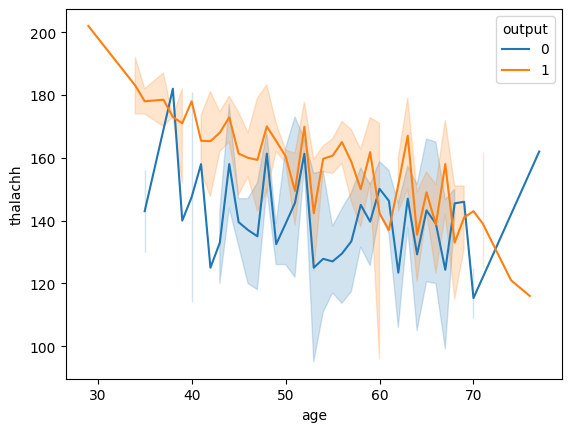

In [17]:
# Max Heart Rate by Age and Heart Disease
sns.lineplot(x='age', y='thalachh', hue='output', data=data)
# That visualizes the relationship between age, maximum heart rate (thalachh), and the presence or absence of heart disease (output).

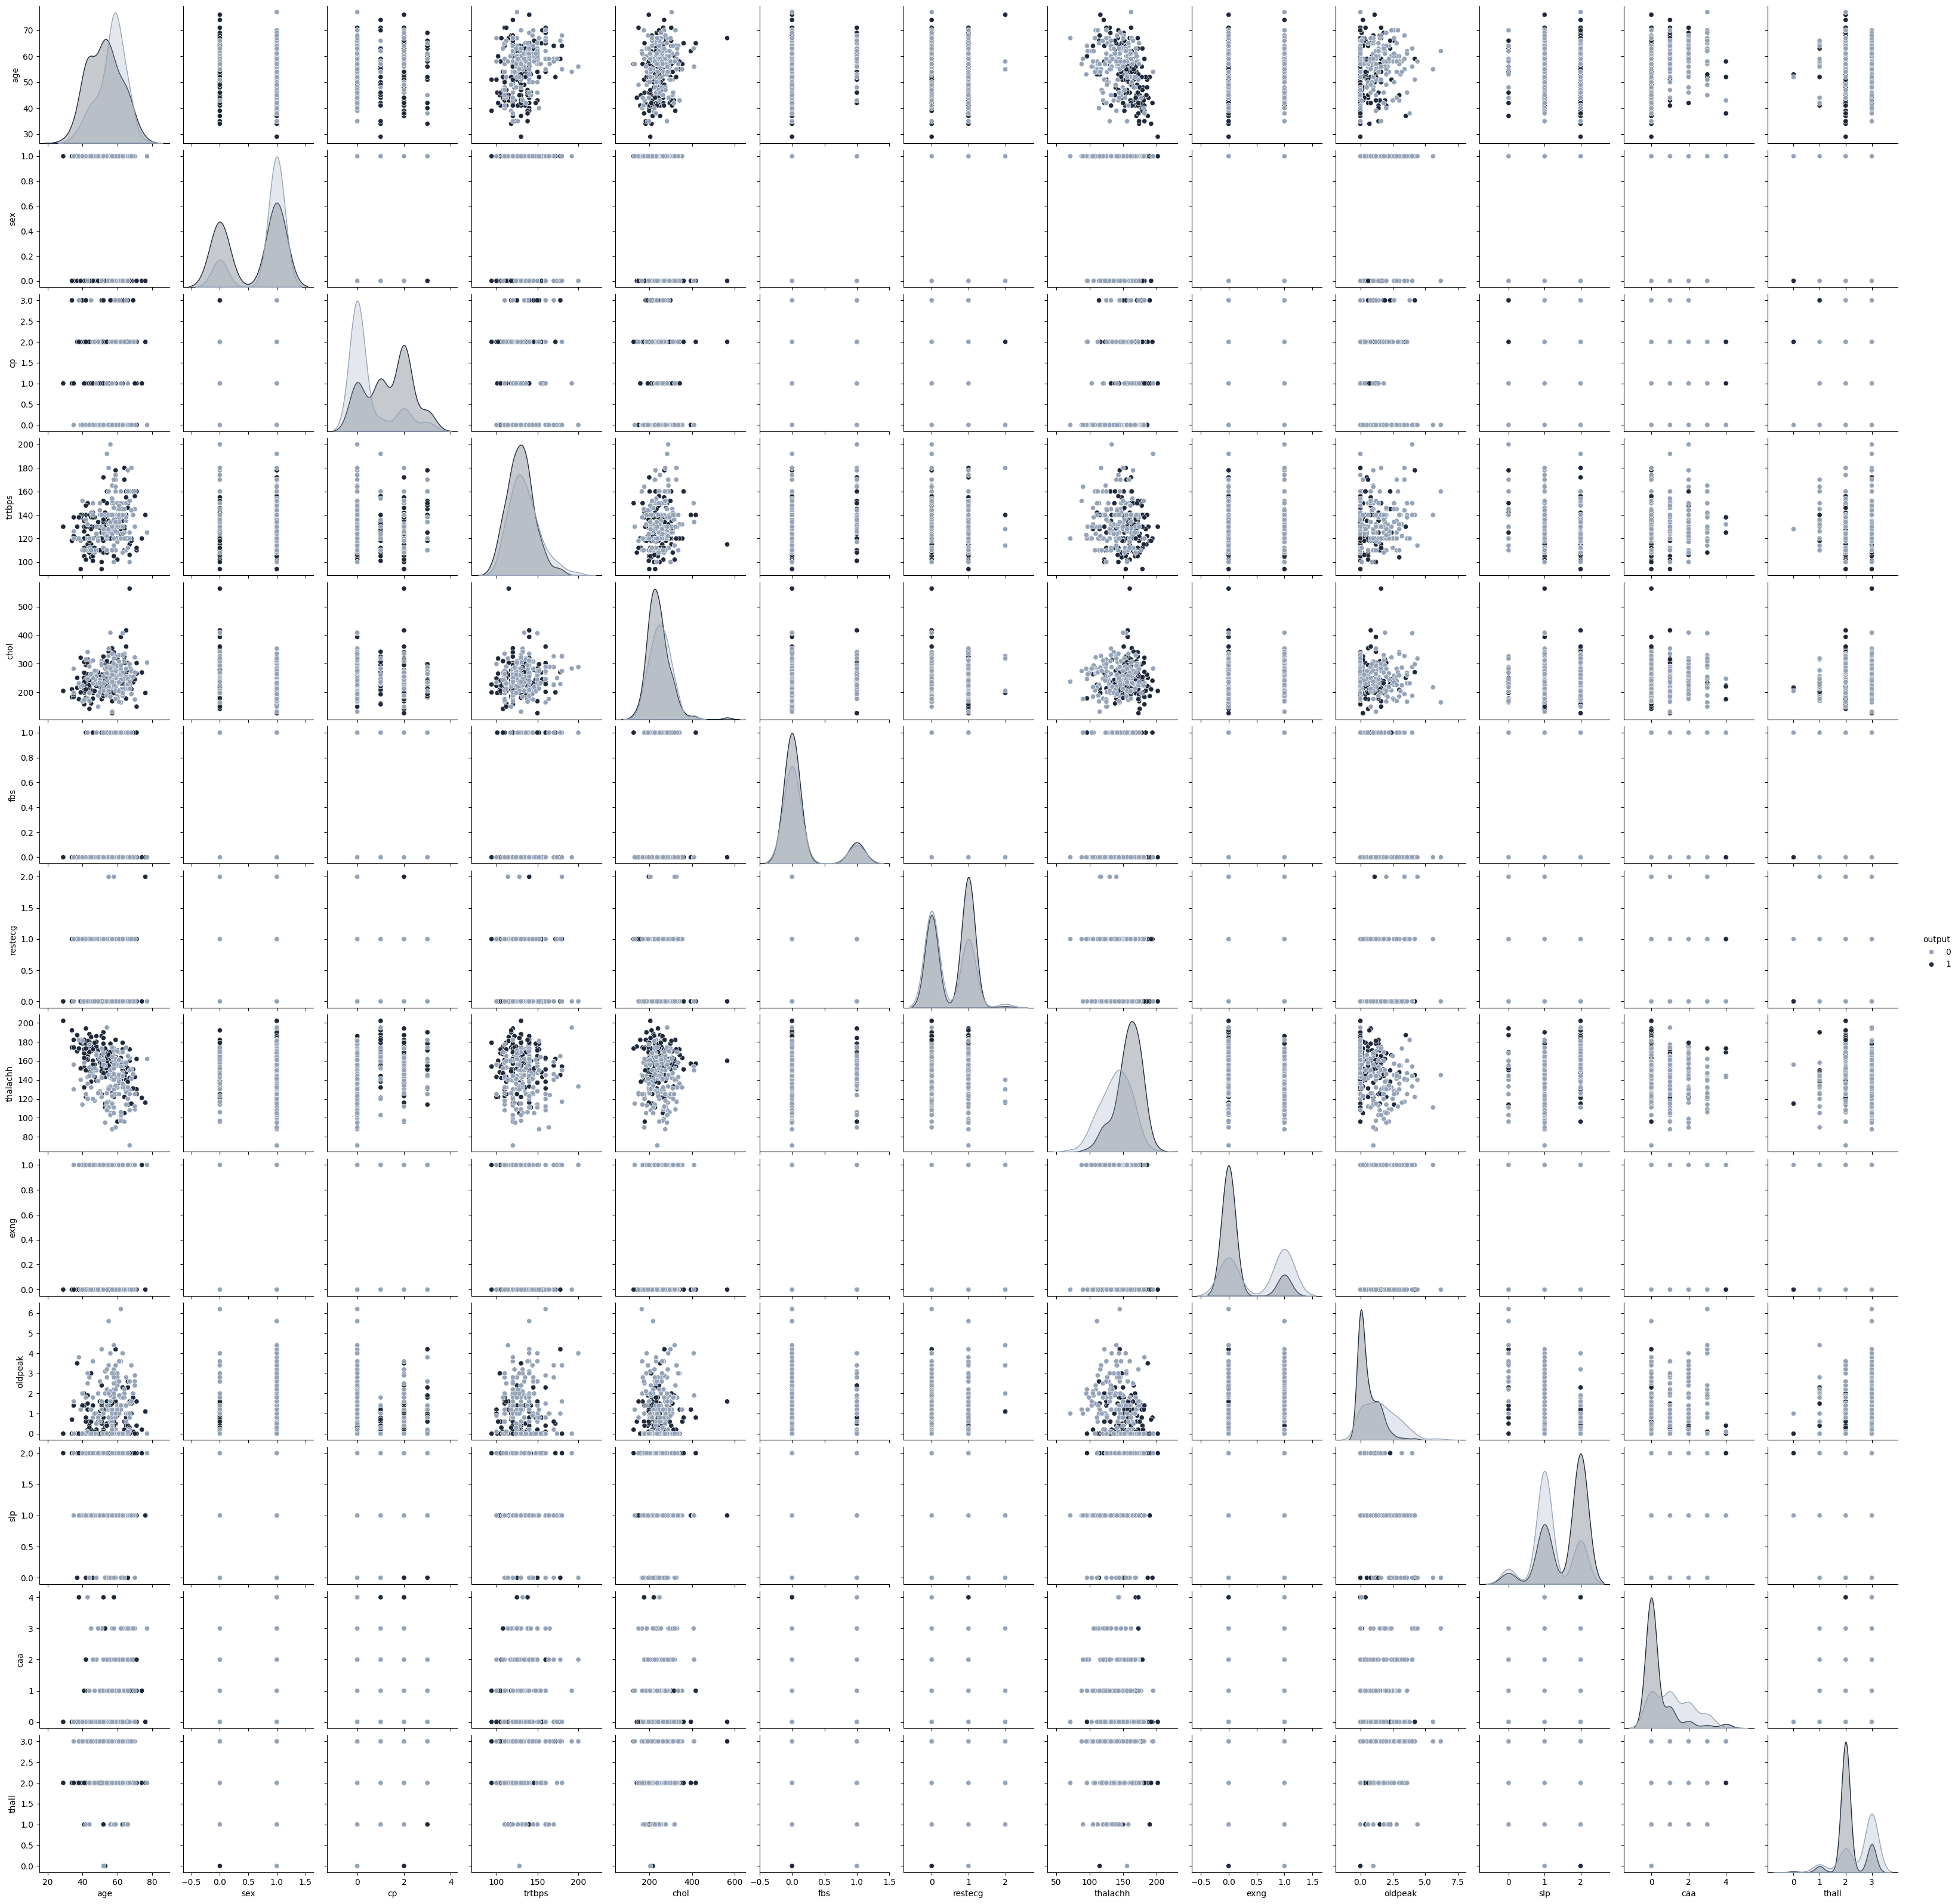

In [18]:
sns.pairplot(data,hue='output',palette = ["#94a3b8", "#1e293b"])
plt.show()

# Conclusion from the EDA
* There is no NaN value in the data.
* Everything that happens has an exit.
* Data shows more than twice as many people having sex = 1 than sex = 0.
* No significant relationship between continuous variables based on temperature.
* The scatter plot matrix shows that there may be a correlation between output and cp, thalachh and slp.
* It is clear that older people may be at higher risk of cardiovascular disease, but based on the age distribution plot for production it is clear that this is not the case.
* According to the scatter plot of Talakh production, people with high current heart rate are likely to have a heart attack.
* According to the scatter plot of old peak production, people with lower  peak production are more likely to have a heart attack.
* Statement 3.2.4 states the following:
 * People with non-anginal chest pain, i.e. cp = 2, have a  higher chance of having a heart attack.
 * People with 0 solid arteries, that is, caa = 0, have a high risk of having a heart attack.
 * People who do Sex = 1 have a higher chance of having a heart attack.  People with
 * Thall = 2 have a higher risk of heart disease.
 * People who do not exercise cause angina pectoris, if exng = 0, the risk of heart attack is high.

# Making features model ready

## Scaling and Encoding features

In [19]:
# Creating a copy of data
data_copy = data

# Define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

# Encoding the categorical columns
data_copy = pd.get_dummies(data_copy, columns = cat_cols, drop_first = True)

# Defining the feature and target
X = data_copy.drop(['output'], axis=1)
y = data_copy[['output']]

# Instantiating the Scaler
scaler = RobustScaler()

# Scaling the continuous features
X[con_cols] = scaler.fit_transform(X[con_cols])
print("The first 5 rows of X are")
X.head()

The first 5 rows of X are


,age,trtbps,chol,thalachh,oldpeak,sex_1,exng_1,caa_1,caa_2,caa_3,...,cp_2,cp_3,fbs_1,restecg_1,restecg_2,slp_1,slp_2,thall_1,thall_2,thall_3
0,0.592593,0.75,-0.110236,-0.092308,0.9375,True,False,False,False,False,...,False,True,True,False,False,False,False,True,False,False
1,-1.333333,0.00,0.157480,1.046154,1.6875,True,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
2,-1.037037,0.00,-0.566929,0.584615,0.3750,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3,0.074074,-0.50,-0.062992,0.769231,0.0000,True,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False
4,0.148148,-0.50,1.795276,0.307692,-0.1250,False,True,False,False,False,...,False,False,False,True,False,False,True,False,True,False


## Train and test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print("The shape of X_train is: ", X_train.shape)
print("The shape of X_test is: ",X_test.shape)
print("The shape of y_train is: ",y_train.shape)
print("The shape of y_test is: ",y_test.shape)

The shape of X_train is:  (242, 22)
The shape of X_test is:  (61, 22)
The shape of y_train is:  (242, 1)
The shape of y_test is:  (61, 1)


# Modeling

## Linear Classifiers
## Support Vector Machines

In [21]:
# Instantiating the object and fitting
clf = SVC(kernel='linear', C=1, random_state=42).fit(X_train,y_train)

# Predicting the values
y_pred = clf.predict(X_test)

# Printing the test accuracy
print("The test accuracy score of SVM is: ", accuracy_score(y_test, y_pred))

The test accuracy score of SVM is:  0.8688524590163934


## Hyperparameter tuning of SVC

In [22]:
# Instantiating the object
svm = SVC()

# Setting a grid - not so extensive
parameters = {"C":np.arange(1,10,1),'gamma':[0.00001,0.00005, 0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5]}

# Instantiating the GridSearchCV object
searcher = GridSearchCV(svm, parameters)

# Fitting the object
searcher.fit(X_train, y_train)

# The scores
print("The best params are: ", searcher.best_params_)
print("The best score is: ", searcher.best_score_)

# Predicting the values
y_pred = searcher.predict(X_test)

# Printing the test accuracy
print("The test accuracy score of SVM after hyper-parameter tuning is: ", accuracy_score(y_test, y_pred))

The best params are:  {'C': 3, 'gamma': 0.1}
The best score is:  0.8384353741496599
The test accuracy score of SVM after hyper-parameter tuning is:  0.9016393442622951


## Logistic Regression

In [23]:
# Instantiating the object
logreg = LogisticRegression()

# Fitting the object
logreg.fit(X_train, y_train)

# Calculating the probabilities
y_pred_proba = logreg.predict_proba(X_test)

# Finding the predicted valued
y_pred = np.argmax(y_pred_proba,axis=1)

# Printing the test accuracy
print("The test accuracy score of Logistric Regression is: ", accuracy_score(y_test, y_pred))

The test accuracy score of Logistric Regression is:  0.9016393442622951


## ROC Curve

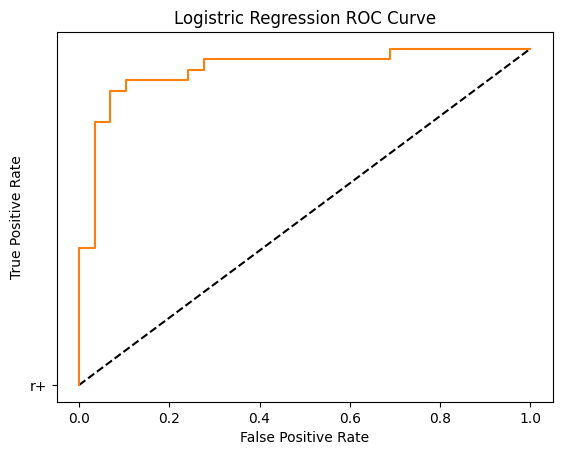

In [24]:
# Calculating the probabilities
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Instantiating the roc_cruve
fpr,tpr,threshols=roc_curve(y_test,y_pred_prob)

# Plotting the curve
plt.plot([0,1],[0,1],"k--",'r+')
plt.plot(fpr,tpr,label='Logistic Regression')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistric Regression ROC Curve")
plt.show()

# Tree Models
## Decision Tree

In [25]:
# Instantiating the object
dtc = DecisionTreeClassifier(random_state = 42)

# Fitting the model
dtc.fit(X_train, y_train)

# Calculating the predictions
y_pred = dtc.predict(X_test)

# Printing the test accuracy
print("The test accuracy score of Decision Tree is: ", accuracy_score(y_test, y_pred))

The test accuracy score of Decision Tree is:  0.7868852459016393


## Random Forest

In [26]:
# Instantiating the object
rf = RandomForestClassifier()

# Fitting the model
rf.fit(X_train, y_train)

# Calculating the predictions
y_pred = dtc.predict(X_test)

# Printing the test accuracy
print("The test accuracy score of Random Forest is: ", accuracy_score(y_test, y_pred))

The test accuracy score of Random Forest is:  0.7868852459016393


## Gradient Boosting Classifier - without tuning

In [27]:
# Instantiate the classifier
gbt = GradientBoostingClassifier(n_estimators = 300,max_depth=1,subsample=0.8,max_features=0.2,random_state=42)

# Fitting the model
gbt.fit(X_train,y_train)

# Predicting values
y_pred = gbt.predict(X_test)
print("The test accuracy score of Gradient Boosting Classifier is: ", accuracy_score(y_test, y_pred))

The test accuracy score of Gradient Boosting Classifier is:  0.8688524590163934
